In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
hi_data = Table.read('fits/hi_data.fits')

masks = Table.read('fits/masks.fits')
halo_data = Table.read('fits/halo_table_all.fits')
halo_data_w_gas = Table.read('fits/halo_table_all_w_gas.fits')

gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
'''
has_mendel = structure_data['ok']
_ = plt.hist(structure_data['PpS_mendel'][has_mendel],alpha=0.5)

for p in np.linspace(5,95,19):
    percentile = np.percentile(structure_data['PpS_mendel'][has_mendel],p)
    print('{}th percentile = {}'.format(p,percentile))
    
_ = plt.xlabel('PpS [Mendel+14]')
_ = plt.ylabel('$N_\mathrm{gal}$')
'''

"\nhas_mendel = structure_data['ok']\n_ = plt.hist(structure_data['PpS_mendel'][has_mendel],alpha=0.5)\n\nfor p in np.linspace(5,95,19):\n    percentile = np.percentile(structure_data['PpS_mendel'][has_mendel],p)\n    print('{}th percentile = {}'.format(p,percentile))\n    \n_ = plt.xlabel('PpS [Mendel+14]')\n_ = plt.ylabel('$N_\\mathrm{gal}$')\n"

In [4]:
def add_halo_frac_columns(halo_data):

    halo_data['M_total_2.2_hernquist'] = (halo_data['M_disc_total_2.2']
                                        + halo_data['M_bulge_2.2']
                                        + halo_data['M_halo_2.2_hernquist'])

    halo_data['bulge_frac_2.2_hernquist'] = (halo_data['M_bulge_2.2']
                                           / halo_data['M_total_2.2_hernquist'])
    halo_data['disc_frac_2.2_hernquist'] = (halo_data['M_disc_total_2.2']
                                          / halo_data['M_total_2.2_hernquist'])
    halo_data['halo_frac_2.2_hernquist'] = (halo_data['M_halo_2.2_hernquist']
                                          / halo_data['M_total_2.2_hernquist'])

    ###########################################################

    halo_data['M_total_2.2_burkert'] = (halo_data['M_disc_total_2.2']
                                        + halo_data['M_bulge_2.2']
                                        + halo_data['M_halo_2.2_burkert'])

    halo_data['bulge_frac_2.2_burkert'] = (halo_data['M_bulge_2.2']
                                         / halo_data['M_total_2.2_burkert'])
    halo_data['disc_frac_2.2_burkert'] = (halo_data['M_disc_total_2.2']
                                        / halo_data['M_total_2.2_burkert'])
    halo_data['halo_frac_2.2_burkert'] = (halo_data['M_halo_2.2_burkert']
                                        / halo_data['M_total_2.2_burkert'])
    
    return halo_data

halo_data = add_halo_frac_columns(halo_data)
halo_data_w_gas = add_halo_frac_columns(halo_data_w_gas)

In [43]:
# --- sample selection:

redshift_ok = masks['in_redshift']
redshift_ok = np.all([morph_data['redshift'] >= 0.01,
                      morph_data['redshift'] <= 0.085],axis=0)
hi_ok = masks['hi_ok']

# Check the structure:
disc_ok = structure_data['PpS_mendel'] <= 0.32 # Mendel+ 2-component system
axial_ok = morph_data['axial_ratio'] >= 0.4 # Hart+17, Masters+10
fit_ok = structure_data['ok']
mass_ok = masks['mass_ok']

star_forming = masks['star_forming']

m_columns = [halo_data['m_hernquist_2R_d'],
             halo_data['m_burkert_2R_d'],
             halo_data_w_gas['m_hernquist_2R_d'],
             halo_data_w_gas['m_burkert_2R_d']]

m_ok = np.all([(m <= 100) & (m >= 0) for m in m_columns],axis=0)
p_spiral_ok = np.isfinite(morph_data['p_spiral'])

in_spiral = np.all([morph_data['p_spiral'] > 0.5,
                    morph_data['N_spiral'] >= 5],axis=0)

sample_ok = np.all([redshift_ok,hi_ok,mass_ok,fit_ok,
                    disc_ok,axial_ok,m_ok,p_spiral_ok],axis=0)
sf_sample = np.all([sample_ok,star_forming],axis=0)
non_sf_sample = np.all([sample_ok,star_forming == False],axis=0)

spiral_sample = np.all([sample_ok,in_spiral],axis=0)
sf_spiral_sample = np.all([spiral_sample,sf_sample],axis=0)
non_sf_spiral_sample = np.all([spiral_sample,non_sf_sample],axis=0)

print('{} discs in the final sample'.format(sample_ok.sum()))
print('{} are SF'.format(sf_sample.sum()))
print('{} are none-SF'.format(non_sf_sample.sum()))

54591 discs in the final sample
27135 are SF
27456 are none-SF


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in greater


#### First: comparison w and w/o gas

In [44]:
from compare_xy import make_figure, comparison_plot
from contours import kde_contour

def xy_plotter(x,y,x2,y2,bins,contour=False,xlabel='x',ylabel='y',letter='a',
               legend=False,figscale=5):

    for v, v_string in zip((x,y,x2,y2),('x','y','x2','y2')):
        median = np.percentile(v,50)
        upper = np.percentile(v,84) - np.percentile(v,50)
        lower = np.percentile(v,50) - np.percentile(v,16)
        print('{} : {} +{} -{}'.format(v_string,median,upper,lower))

    fig, axarr = make_figure(figscale)
    _ = axarr[0].hist(x,bins,normed=True,
                      color='g',histtype='stepfilled',alpha=0.2)
    _ = axarr[0].hist(x,bins,normed=True,
                      color='g',lw=1,histtype='step')
    _ = axarr[0].hist(x2,bins,normed=True,
                      color='purple',histtype='step',lw=3)

    _ = axarr[1].hist(y,bins,normed=True,
                      color='g',histtype='stepfilled',alpha=0.2,
                      orientation='horizontal')
    _ = axarr[1].hist(y,bins,normed=True,
                      color='g',lw=1,histtype='step',
                      orientation='horizontal')
    _ = axarr[1].hist(y2,bins,normed=True,
                      color='purple',histtype='step',lw=3,
                      orientation='horizontal')

    _ = axarr[2].scatter(x[:5000],y[:5000],
                         color='g',s=1,zorder=0,
                         rasterized=True,label='stars')

    _ = axarr[2].scatter(x2[:5000],y2[:5000],
                         color='purple',s=1,zorder=0,
                         rasterized=True,label='stars+gas')
    
    if contour is True:
        plt.sca(axarr[2])
        _ = kde_contour(x,y,N_max=100,fill=True,zorder=1,
                        fill_properties={'colormap':'Greens'},
                        line_properties={'color':'g'})
        _ = kde_contour(x2,y2,N_max=100,fill=False,zorder=1,
                        line_properties={'color':'purple',
                                         'linewidth':2})

    _ = axarr[2].plot([bins[0],bins[-1]],[bins[0],bins[-1]],color='k',lw=1)
    _ = axarr[2].set_xlim(bins[0],bins[-1])
    _ = axarr[2].set_ylim(bins[0],bins[-1])
    _ = axarr[2].set_xlabel(xlabel)
    _ = axarr[2].set_ylabel(ylabel)
    _ = axarr[2].text(0.05,0.95,'({})'.format(letter),
                      ha='left',va='top',transform=axarr[2].transAxes)
    if legend is True:
        _ = axarr[2].legend(fancybox=False,edgecolor='k')
    return fig, axarr

#fig.savefig('figures/fd_vs_fd.pdf')

x : 0.23332657277355284 +0.14242457267019992 -0.1051133665969069
y : 0.3835918142846624 +0.24908770123393764 -0.16794040145233036
x2 : 0.3146205474197393 +0.13454547681258028 -0.10512720949799131
y2 : 0.47947873656190315 +0.2592542601217492 -0.1665318757551713
x : 6.592290991546753 +5.004567081225184 -2.206645683230179
y : 3.4508949085507337 +1.9262159218847485 -0.9640494548835954
x2 : 5.594481648710126 +2.331375219100506 -1.4495807416887718
y2 : 3.0939522929402816 +1.0537779130146872 -0.6986382245877651
x : 1.0140025084062771 +0.07464728003349164 -0.0834852819833165
y : 1.1155836576766438 +0.11472521404219949 -0.08227568068493651
x2 : 1.0124632248340082 +0.05751979123283779 -0.056623044271076006
y2 : 1.0874583610468807 +0.09020831418329878 -0.06126582252227375
x : 21.587792849582733 +2.5953978383990197 -2.0773000127026755
y : 18.809992203476448 +2.2202081259408857 -2.736624125341816
x2 : 21.632898289727002 +1.729592886583056 -1.6223109378164935
y2 : 19.542047028435977 +1.6919349561058

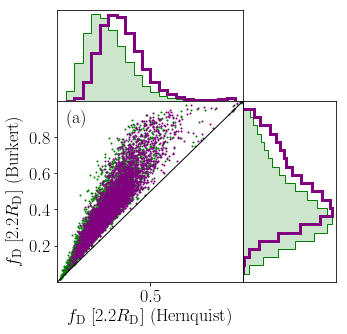

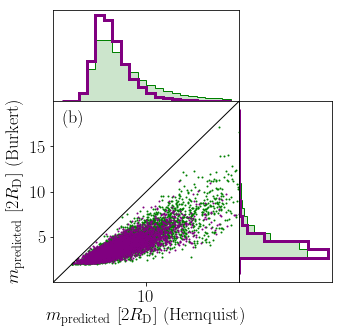

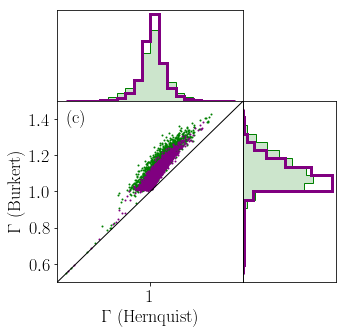

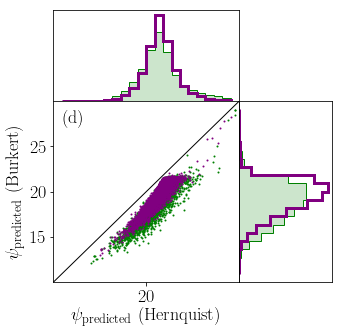

In [41]:
x = halo_data['disc_frac_2.2_hernquist'][sample_ok]
y = halo_data['disc_frac_2.2_burkert'][sample_ok]
x2 = halo_data_w_gas['disc_frac_2.2_hernquist'][sample_ok]
y2 = halo_data_w_gas['disc_frac_2.2_burkert'][sample_ok]
bins = np.linspace(0,1,21)
xlabel = '$f_\mathrm{D}$ [$2.2R_\mathrm{D}$] (Hernquist)'
ylabel = '$f_\mathrm{D}$ [$2.2R_\mathrm{D}$] (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'a')
fig.savefig('figures/fd_vs_fd.pdf')

##################################################

x = halo_data['m_hernquist_2R_d'][sample_ok]
y = halo_data['m_burkert_2R_d'][sample_ok]
x2 = halo_data_w_gas['m_hernquist_2.2R_d'][sample_ok]
y2 = halo_data_w_gas['m_burkert_2.2R_d'][sample_ok]
bins = np.linspace(0,20,21)
xlabel = '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$] (Hernquist)'
ylabel = '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$] (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'b')
_ = axarr[2].set_yticks([5,10,15])
fig.savefig('figures/mp_vs_mp.pdf')

###################################################

x = halo_data['Gamma_hernquist'][sample_ok]
y = halo_data['Gamma_burkert'][sample_ok]
x2 = halo_data_w_gas['Gamma_hernquist'][sample_ok]
y2 = halo_data_w_gas['Gamma_burkert'][sample_ok]
bins = np.linspace(0.5,1.5,21)
xlabel = '$\Gamma$ (Hernquist)'
ylabel = '$\Gamma$ (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'c')
fig.savefig('figures/Gamma_vs_Gamma.pdf')

###################################################

x = halo_data['psi_hernquist'][sample_ok]
y = halo_data['psi_burkert'][sample_ok]
x2 = halo_data_w_gas['psi_hernquist'][sample_ok]
y2 = halo_data_w_gas['psi_burkert'][sample_ok]
bins = np.linspace(10,30,21)
xlabel = '$\psi_\mathrm{predicted}$ (Hernquist)'
ylabel = '$\psi_\mathrm{predicted}$ (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'d')
_ = axarr[2].set_yticks([15,20,25])
fig.savefig('figures/psip_vs_psip.pdf')

x : 0.22047089471912162 +0.1489709156585325 -0.10367168341376068
y : 0.4360145605606449 +0.26140674276790343 -0.2095598359193712
x2 : 0.32115802421121303 +0.12803839889275415 -0.1033135221977966
y2 : 0.5669851426206683 +0.22816821697613088 -0.21580174130726776
x : 7.314595948865183 +5.905547884566365 -2.664610010032453
y : 3.153041148204879 +2.0267965262624306 -0.8098923894890415
x2 : 5.779087108088993 +2.1903270354305997 -1.4396196594881125
y2 : 2.795228568478477 +1.0490580550852409 -0.49389856544930977
x : 0.9807140025732846 +0.05500619938300311 -0.08026568469299766
y : 1.063591923893357 +0.09594612389490154 -0.04919232734718393
x2 : 0.9887006045464928 +0.039672705497882266 -0.04571966337430422
y2 : 1.0458313393703675 +0.06424395455260878 -0.03215154411213916
x : 22.58540528135065 +2.613427136842109 -1.6238383319802487
y : 20.184666555816808 +1.3915061958437462 -2.4678933464992916
x2 : 22.34174416329361 +1.433671377779639 -1.1704305351425184
y2 : 20.67633139158168 +0.9209098504286679

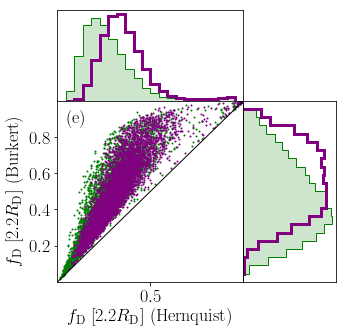

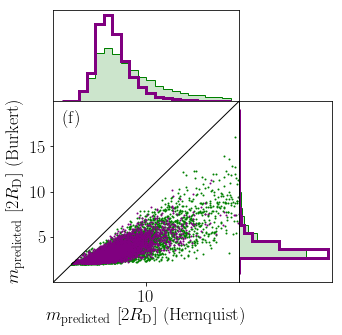

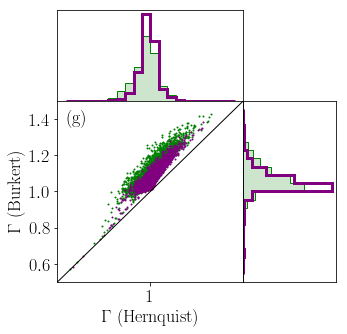

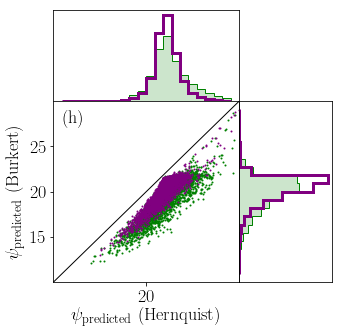

In [45]:
x = halo_data['disc_frac_2.2_hernquist'][spiral_sample]
y = halo_data['disc_frac_2.2_burkert'][spiral_sample]
x2 = halo_data_w_gas['disc_frac_2.2_hernquist'][spiral_sample]
y2 = halo_data_w_gas['disc_frac_2.2_burkert'][spiral_sample]
bins = np.linspace(0,1,21)
xlabel = '$f_\mathrm{D}$ [$2.2R_\mathrm{D}$] (Hernquist)'
ylabel = '$f_\mathrm{D}$ [$2.2R_\mathrm{D}$] (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'e')
fig.savefig('figures/fd_vs_fd_spiral.pdf')

##################################################

x = halo_data['m_hernquist_2R_d'][spiral_sample]
y = halo_data['m_burkert_2R_d'][spiral_sample]
x2 = halo_data_w_gas['m_hernquist_2.2R_d'][spiral_sample]
y2 = halo_data_w_gas['m_burkert_2.2R_d'][spiral_sample]
bins = np.linspace(0,20,21)
xlabel = '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$] (Hernquist)'
ylabel = '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$] (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'f')
_ = axarr[2].set_yticks([5,10,15])
fig.savefig('figures/mp_vs_mp_spiral.pdf')

###################################################

x = halo_data['Gamma_hernquist'][spiral_sample]
y = halo_data['Gamma_burkert'][spiral_sample]
x2 = halo_data_w_gas['Gamma_hernquist'][spiral_sample]
y2 = halo_data_w_gas['Gamma_burkert'][spiral_sample]
bins = np.linspace(0.5,1.5,21)
xlabel = '$\Gamma$ (Hernquist)'
ylabel = '$\Gamma$ (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'g')
fig.savefig('figures/Gamma_vs_Gamma_spiral.pdf')

###################################################

x = halo_data['psi_hernquist'][spiral_sample]
y = halo_data['psi_burkert'][spiral_sample]
x2 = halo_data_w_gas['psi_hernquist'][spiral_sample]
y2 = halo_data_w_gas['psi_burkert'][spiral_sample]
bins = np.linspace(10,30,21)
xlabel = '$\psi_\mathrm{predicted}$ (Hernquist)'
ylabel = '$\psi_\mathrm{predicted}$ (Burkert)'

fig, axarr = xy_plotter(x,y,x2,y2,bins,False,xlabel,ylabel,'h')
_ = axarr[2].set_yticks([15,20,25])
fig.savefig('figures/psip_vs_psip_spiral.pdf')

In [38]:
from uncertainties import ufloat as uf

def mass_error(v,delta_v):
    print(uf(v,delta_v)**2)
    return None

mass_error(0.63,0.1) # Bottema 93
mass_error(0.53,0.04) # Kregel 05
mass_error(0.47,0.08) # Bershady 11
mass_error(0.57,0.07) # Martinsson 11

0.40+/-0.13
0.28+/-0.04
0.22+/-0.08
0.32+/-0.08


#### Now make equivalent plots at 2.2R_d?

In [ ]:
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,4,figsize=(20,10),sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

y = halo_data_w_gas['m_burkert_2R_d']
x_columns = ['M_bulge_2.2','M_disc_total_2.2','M_halo_2.2_burkert',
             'M_total_2.2_burkert','bulge_frac_2.2_burkert',
             'disc_frac_2.2_burkert','halo_frac_2.2_burkert']
xs = [np.log10(halo_data_w_gas[c]) for c in x_columns]
xlabels = ['$\log(\mathrm{M_B}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_D}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_h}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_{total}}) \, [2.2R_\mathrm{D}]$',
           '$\log(f_\mathrm{B}) \, [2.2R_\mathrm{D}]$',
           '$\log(f_\mathrm{D}) \, [2.2R_\mathrm{D}]$',
           '$\log(f_\mathrm{h}) \, [2.2R_\mathrm{D}]$']

colors = 'rbkyrbk'

for x, xlabel, ax, color in zip(xs,xlabels,axarr,colors):
    
    xy = x_vs_y(x[sample_ok],y[sample_ok])
    xy.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy.line_plot(ax,color='k',lw=3,linestyle='solid')
    xy.error_plot(ax,color='k',style='filled',
                  alpha=0.2)
    
    xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample])
    xy_nsf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_nsf.line_plot(ax,color='r',lw=2)
    xy_nsf.error_plot(ax,color='r',alpha=0.2)
    
    xy_sf = x_vs_y(x[sf_sample],y[sf_sample])
    xy_sf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_sf.line_plot(ax,color='b',lw=3,linestyle='dashed')
    xy_sf.error_plot(ax,color='b',style='lined',lw=2,linestyle='dashed')
    
    ax.set_xlabel(xlabel)
    
_ = fig.text(0.08, 0.5, '$m_\mathrm{predicted}$', va='center', rotation='vertical')

In [ ]:
#### Now: is there a notable drop off in p_spiral at that mass?
fig, axarr = plt.subplots(2,4,figsize=(20,10),sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

y = np.all([morph_data['p_spiral'] >= 0.5,
            morph_data['N_spiral'] >= 5],axis=0)

for x, xlabel, ax, color in zip(xs,xlabels,axarr,colors):
    
    xy = x_vs_y(x[sample_ok],y[sample_ok])
    xy.fraction_with_feature(bins=20,equal_N=True)
    xy.line_plot(ax,color='k',lw=3,linestyle='solid')
    xy.error_plot(ax,color='k',style='filled',
                  alpha=0.2)
    
    xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample])
    xy_nsf.fraction_with_feature(bins=20,equal_N=True)
    xy_nsf.line_plot(ax,color='r',lw=2)
    xy_nsf.error_plot(ax,color='r',alpha=0.2)
    
    xy_sf = x_vs_y(x[sf_sample],y[sf_sample])
    xy_sf.fraction_with_feature(bins=20,equal_N=True)
    xy_sf.line_plot(ax,color='b',lw=3,linestyle='dashed')
    xy_sf.error_plot(ax,color='b',style='lined',lw=2,linestyle='dashed')
    
    ax.set_xlabel(xlabel)
    
_ = fig.text(0.08, 0.5, '$f_\mathrm{spiral}$', va='center', rotation='vertical')

In [ ]:
_ = plt.scatter(halo_data['disc_frac_2.2_hernquist'][sample_ok],
                halo_data['m_hernquist_2R_d'][sample_ok]*(1.5/1.75),
                color='r',s=1,alpha=0.2,label='$2R_\mathrm{D}$')

_ = plt.scatter(halo_data['disc_frac_2.2_hernquist'][sample_ok],
                halo_data['m_hernquist_1.5R_d'][sample_ok]*(1.5/1.75),
                color='k',s=1,alpha=0.2,label='$1.5R_\mathrm{D}$')

_ = plt.scatter(halo_data['disc_frac_2.2_hernquist'][sample_ok],
                halo_data['m_hernquist_1R_d'][sample_ok]*(1.5/1.75),
                color='m',s=1,alpha=0.2,label='$1R_\mathrm{D}$')

_ = plt.xlim(0,1)
_ = plt.ylim(0,8)

xmarkers = [0.21,0.17,0.32,0.4,0.46,0.52,0.28,0.41,0.35,0.23,0.3]
ymarkers = [6.1,4.8,5.6,4,2.8,3.3,4.4,2.6,3.6,5.3,3.3]
_ = plt.scatter(xmarkers,ymarkers,s=50,color='b',marker='o',
                label='Martinsson+13')

_ = plt.scatter(0.7,2.2,color='limegreen',s=50,marker='s',label='MW')

_ = plt.xlabel('$f_d$ [$2.2R_d$]')
_ = plt.ylabel('$m_\mathrm{predicted}$ [$2R_d$]')
_ = plt.legend()

In [ ]:
_ = plt.scatter(halo_data['disc_frac_2.2_burkert'][sample_ok],
                halo_data['m_burkert_2R_d'][sample_ok]*(1.5/1.75),
                color='r',s=1,alpha=0.2,label='$2R_\mathrm{D}$')

_ = plt.scatter(halo_data['disc_frac_2.2_burkert'][sample_ok],
                halo_data['m_burkert_1.5R_d'][sample_ok]*(1.5/1.75),
                color='k',s=1,alpha=0.2,label='$1.5R_\mathrm{D}$')

_ = plt.scatter(halo_data['disc_frac_2.2_burkert'][sample_ok],
                halo_data['m_burkert_1R_d'][sample_ok]*(1.5/1.75),
                color='m',s=1,alpha=0.2,label='$1R_\mathrm{D}$')

_ = plt.xlim(0,1)
_ = plt.ylim(0,8)

xmarkers = [0.21,0.17,0.32,0.4,0.46,0.52,0.28,0.41,0.35,0.23,0.3]
ymarkers = [6.1,4.8,5.6,4,2.8,3.3,4.4,2.6,3.6,5.3,3.3]
_ = plt.scatter(xmarkers,ymarkers,s=50,color='b',marker='o',
                label='Martinsson+13')

_ = plt.scatter(0.7,2.2,color='limegreen',s=50,marker='s',label='MW')

_ = plt.xlabel('$f_d$ [$2.2R_d$]')
_ = plt.ylabel('$m_\mathrm{predicted}$ [$2R_d$]')
_ = plt.legend()

#### What have we learned here?

We see that galaxies with more massive discs are predicted to have fewer spiral arms. We see that there is no drop-off in the Galaxy Zoo $p_\mathrm{spiral}$ statistic with predicted arm number.

Now: form either a $f_\mathrm{D}$ - $m$ space or an $m_\mathrm{predicted}$ - $m$ space to investigate any correlations with Galaxy Zoo data.

In [ ]:
p_spiral = morph_data['p_spiral']
N_spiral = morph_data['N_spiral']
p_bar = morph_data['p_bar']

spiral_ok = np.all([p_spiral > 0.5,N_spiral >= 5, p_bar <= 0.2],axis=0)
#spiral_ok = np.all([p_spiral>0.8,N_spiral>=5,
                    #morph_data['p_m']>=0.75],axis=0)
spiral_sample = np.all([sample_ok,spiral_ok],axis=0)
spiral_sf = np.all([sf_sample,spiral_ok],axis=0)
spiral_non_sf = np.all([non_sf_sample,spiral_ok],axis=0)

x = halo_data_w_gas['m_burkert_2R_d'][spiral_sample]
y0 = morph_data['m_avg'][spiral_sample]
y1 = morph_data['m'][spiral_sample]

xys = [x_vs_y(x,y0).continuous_vs_continuous_binned_mean(equal_N=True),
       x_vs_y(y0,x).continuous_vs_continuous_binned_mean(equal_N=True),
       x_vs_y(x,y1).continuous_vs_continuous_binned_mean(equal_N=True),
       x_vs_y(y1,x).discrete_vs_continuous_binned_mean()]

xy_data = [(x,y0),(y0,x),(x,y1),(y1,x)]

xlabels = ('$m_\mathrm{predicted}$ [$2R_\mathrm{D}$]',
           '$m_\mathrm{avg}$ [GZ2]',
           '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$]',
           '$m$ [GZ2]')

ylabels = ('$m_\mathrm{avg}$ [GZ2]',
           '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$]',
           '$m$ [GZ2]',
           '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$]')

fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
axarr[0].set_xlim(0,5)
axarr[0].set_ylim(0,5)

for ax, xy, xy_, xlabel, ylabel in zip(axarr,xys,xy_data,xlabels,ylabels):
    ax.scatter(xy_[0],xy_[1],color='k',s=2,alpha=0.2)
    xy.error_plot(ax,style='errorbar',color='r',lw=2,capsize=2)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    
fig.tight_layout()

#### The last thing we can do for this section: look for a third variable which we perhaps expect to correlate with modal spiral arms

In [ ]:
from contours3 import xyz_contour

test_sample = np.all([spiral_sample,
                      halo_data_w_gas['m_burkert_2R_d'] <= 5],axis=0)


x = morph_data['m_avg'][test_sample]
y = halo_data_w_gas['m_burkert_2R_d'][test_sample]
z = gz2_data['IVAN_DENSITY'][test_sample]

fig, axarr = plt.subplots(2,2,figsize=(20,16))
axarr = axarr.ravel()

#############################
ax = axarr[0]
plt.sca(ax)
_ = xyz_contour(x,y,z,fill_properties={'colormap':'viridis'})
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('$\Sigma$ (Baldry+)', rotation=270)
_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#############################
ax = axarr[1]
plt.sca(ax)
z = morph_data['axial_ratio'][test_sample]
_ = xyz_contour(x,y,z,fill_properties={'colormap':'viridis'})
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('$(b/a)_g$', rotation=270)
_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#############################
ax = axarr[2]
plt.sca(ax)
z = gz2_data['t10_arms_winding_a30_loose_debiased_rh'][test_sample]
_ = xyz_contour(x,y,z,fill_properties={'colormap':'viridis'})
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('$p_\mathrm{loose}$ [GZ2]', rotation=270)
_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

fig.delaxes(axarr[-1])
fig.tight_layout()

#### What I've learned from D'Onghia+13

Spiral arms are seeded by a pertubation. The pertubation in question is the formation of GMCs. therefore, we expect spiral arms to form modally when GMCs are present. This may manifest itself in three detectable ways:

- Total SFR: if the molecular gas fraction is high, more GMCs can form.
- $SFR_{22}/SFR_{FUV}$: this is an interesting one. in Hart+17a, we postualted that the GMCs are larger in more dust obscured galaxies: a greater level of dust obscuration may be indicative of clumpy GMCs, which could seed spiral arms.
- $f_\mathrm{gas}$: if the atomic gas fraction is higher, then the molecular gas fraction may be higher, but I believe the correlation is fairly loose (eg. Fig. 8 of Saintonge+11a). 

In [ ]:
# Load the SFR data:
sfrs = Table.read('../fits/SF_fits/sfrs+ids.fits')

has_sfr = np.all([sfrs['F'] >= 2,sfrs['w4'] >= 2],axis=0) 
# ^ note to self: check this is the selection of Hart+17a
test_sample_w_sfr = np.all([test_sample,has_sfr],axis=0)
print('{} spirals have measured SFRS'.format(test_sample_w_sfr.sum()))

f_gas = 1 - (halo_data_w_gas['M_disc_stars']
           / halo_data_w_gas['M_disc_total'])

In [ ]:
x = morph_data['m_avg'][test_sample]
y = halo_data_w_gas['m_burkert_2R_d'][test_sample]
z = f_gas[test_sample]

fig, axarr = plt.subplots(2,2,figsize=(20,16))
axarr = axarr.ravel()

#############################
ax = axarr[0]
plt.sca(ax)
_ = xyz_contour(x,y,z,fill_properties={'colormap':'viridis'})
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('$f_\mathrm{HI}$ (disc)', rotation=270)
_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#############################
ax = axarr[1]
plt.sca(ax)
x = morph_data['m_avg'][test_sample_w_sfr]
y = halo_data_w_gas['m_burkert_2R_d'][test_sample_w_sfr]
z = sfrs['sfr_total'][test_sample_w_sfr]
_ = xyz_contour(x,y,z,fill_properties={'colormap':'viridis'})
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('$SFR_\mathrm{total}$ [$\log(\mathrm{M_\odot \, yr^{-1}})$]' , rotation=270)
_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#############################
ax = axarr[2]
plt.sca(ax)
z = sfrs['mir_fraction'][test_sample_w_sfr]
_ = xyz_contour(x,y,z,fill_properties={'colormap':'viridis'})
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label('$SFR_\mathrm{22}/SFR_\mathrm{total}$', rotation=270)
_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

fig.delaxes(axarr[-1])
fig.tight_layout()

#### Case study: two arm spirals?

In [ ]:
two_arm_sample = np.all([spiral_sample,morph_data['m'] == 2],axis=0)
fig, axarr = plt.subplots(2,2,figsize=(10,10))
axarr = axarr.ravel()

ax = axarr[0]
x = halo_data_w_gas['m_burkert_2R_d'][two_arm_sample]
y = morph_data['p_bar'][two_arm_sample]
#_ = ax.scatter(x,y,color='k',s=2,alpha=0.2)
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=10,equal_N=True)
xy.line_plot(ax,color='k')
xy.error_plot(ax,color='k',alpha=0.2)
_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel('$p_\mathrm{bar}$ [GZ2]')

ax = axarr[1]
y = gz2_data['IVAN_DENSITY'][two_arm_sample]
#_ = ax.scatter(x,y,color='k',s=2,alpha=0.2)
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=10,equal_N=True)
xy.line_plot(ax,color='k')
xy.error_plot(ax,color='k',alpha=0.2)
_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel('$\Sigma_\mathrm{Baldry+}$')

ax = axarr[2]
y = gz2_data['t10_arms_winding_a30_loose_debiased_rh'][two_arm_sample]
#_ = ax.scatter(x,y,color='k',s=2,alpha=0.2)
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=10,equal_N=True)
xy.line_plot(ax,color='k')
xy.error_plot(ax,color='k',alpha=0.2)
_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel('$p_\mathrm{loose}$ [GZ2]')

ax = axarr[3]
y = morph_data['axial_ratio'][two_arm_sample]
#_ = ax.scatter(x,y,color='k',s=2,alpha=0.2)
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=10,equal_N=True)
xy.line_plot(ax,color='k')
xy.error_plot(ax,color='k',alpha=0.2)
_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel('$(b/a)_g$')

_ = fig.tight_layout()

#### What can sparcfire give us?

Nothing...

In [ ]:
sparcfire_data = Table.read('../sparcfire2/fits/galaxy_level_all.fits')
sparcfire_arcs = Table.read('../sparcfire2/fits/arc_table_all.fits')

In [ ]:
def theta_at_r(arc_row,r):
    r_i = arc_row['math_initial_radius']
    psi = arc_row['pitch_angle']*(2*math.pi/360)
    theta_i = arc_row['math_initial_theta']
    r0 = r_i/np.exp(-psi*theta_i)
    theta_r = -np.log(r/r0)/psi
    return theta_r

def theta_difference(arcs,id_):
    id_rows = arcs['gxyName'] == id_
    id_arcs = arcs[id_rows]
    
    arc_0 = id_arcs[0]
    r_centre = arc_0['r_end'] - arc_0['r_start']
    theta_0 = theta_at_r(arc_0,r_centre)
    delta_thetas = []
    for arc_n in id_arcs[1:]:
        theta_n = theta_at_r(arc_n,r_centre)
        delta_theta = (theta_n - theta_0)*(360/(2*math.pi))
        N360 = np.floor(delta_theta/360)
        delta_thetas.append(delta_theta - N360*360)
    return delta_thetas

In [ ]:
in_spiral = np.all([morph_data['p_spiral'] > 0.5,
                    morph_data['N_spiral'] >= 5],axis=0)

unbarred = morph_data['p_bar'] <= 0.2

m_2 = np.all([morph_data['m'] == 2,in_spiral],axis=0)
m_2_sample = np.all([m_2,sample_ok,unbarred],axis=0)

N_arcs = sparcfire_data['N_arcs'] 
multi_arcs = N_arcs > 1
m_2_ids = gz2_data['dr8objid'][(m_2_sample) & (multi_arcs)]

delta_theta_list = []

for id_ in m_2_ids:
    delta_theta_list.append(theta_difference(sparcfire_arcs,id_)[0])
    
delta_thetas = np.array(delta_theta_list)
delta_thetas[np.isfinite(delta_thetas) == False] = -999

arm_symmetry = np.abs(delta_thetas - 180)

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

mask = np.all([arm_symmetry > 0,arm_symmetry < 180],axis=0) 
x = halo_data_w_gas['m_burkert_2R_d'][(m_2_sample) & (multi_arcs)][mask]
y = arm_symmetry[mask]
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=12,
                                                        equal_N=True)

xy.line_plot(ax,color='g')
xy.error_plot(ax,color='g',alpha=0.2)

_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel(r'$|\Delta \theta - 180^{\mathrm{o}}|$')